In [2]:
import yfinance as yf
import pandas as pd
import datetime
from statistics import mean
import matplotlib.pyplot as plt #pyplot package under the matplotlib package
import seaborn as sns
%matplotlib inline 

In [407]:
ticker = yf.Ticker("fb")

# set user input parameters

In [408]:
risk_free_rate = 0.02

In [409]:
market_return_rate = 0.1

In [410]:
cap_growth = 1.15

# Custom functions 

In [411]:
def clean_dataframe(frame):
    frame = frame.T.rename_axis('year').reset_index()
    frame["year"] = pd.DatetimeIndex(frame["year"]).year
    frame = frame.sort_values(by=['year'], ascending=False)
    frame.fillna(0, inplace=True)
    return frame

In [412]:
def get_DCF_value(history):
    #create empty growth list
    growth_history = []
    
    #calculate the growth between each year. add to the list
    for i in range(0,(len(ocf_history)-1)):
        growth = (history[i] - history[i+1]) / abs(history[i+1])    
        growth_history.append(growth)
    
    #get the average growth
    average_growth_rate = 1 + mean(growth_history)
    
    #for year 4-10, if average growth in year 1-3 is more than 15%, cap it at 15%
    if average_growth_rate > cap_growth: 
        average_growth_rate_cap = cap_growth
    else: 
        average_growth_rate_cap = average_growth_rate
        
    #project future cash flow (loop properly)
    future_value = []
    start_value = history[0]
    for i in range(1, 11):
        #for year 1 - 3, grow by average growth rate
        if i <= 3:
            value =  start_value * average_growth_rate
            future_value.append(value)
            start_value = value
        #for year 4-10, grow by cap growth rate
        elif i > 3:
            value =  start_value * average_growth_rate_cap
            future_value.append(value)
            start_value = value

    # convert future values into present value and sum them
    present_value = 0 

    for i in range(0, len(future_value)):
        value = future_value[i] / pow(wacc, (i+1))
        present_value += value
    
    #calculate present value per share
    fair_value = present_value/shares
    
    return fair_value

In [413]:
def perpetual_growth_valuation(history):
    growth_history = []
    
    #calculate the growth between each year. add to the list
    for i in range(0,(len(history)-1)):
        growth = (history[i] - history[i+1]) / abs(history[i+1])    
        growth_history.append(growth)

    #get the minimum growth
    min_growth_rate = 1 + min(growth_history)

    #bring to current year and then project for next year. assuming we missed this year's payment
    next_payment = history[0] * min_growth_rate * min_growth_rate 

    #apply formula
    valuation = next_payment / (wacc - min_growth_rate)
    return valuation

# Download fundementals

In [414]:
ticker.info.keys()

dict_keys(['zip', 'sector', 'fullTimeEmployees', 'longBusinessSummary', 'city', 'phone', 'state', 'country', 'companyOfficers', 'website', 'maxAge', 'address1', 'industry', 'ebitdaMargins', 'profitMargins', 'grossMargins', 'operatingCashflow', 'revenueGrowth', 'operatingMargins', 'ebitda', 'targetLowPrice', 'recommendationKey', 'grossProfits', 'freeCashflow', 'targetMedianPrice', 'currentPrice', 'earningsGrowth', 'currentRatio', 'returnOnAssets', 'numberOfAnalystOpinions', 'targetMeanPrice', 'debtToEquity', 'returnOnEquity', 'targetHighPrice', 'totalCash', 'totalDebt', 'totalRevenue', 'totalCashPerShare', 'financialCurrency', 'revenuePerShare', 'quickRatio', 'recommendationMean', 'exchange', 'shortName', 'longName', 'exchangeTimezoneName', 'exchangeTimezoneShortName', 'isEsgPopulated', 'gmtOffSetMilliseconds', 'quoteType', 'symbol', 'messageBoardId', 'market', 'annualHoldingsTurnover', 'enterpriseToRevenue', 'beta3Year', 'enterpriseToEbitda', '52WeekChange', 'morningStarRiskRating', 'f

In [415]:
shares = ticker.info["sharesOutstanding"]
market_cap = ticker.info["marketCap"]
# total_debt = ticker.info["totalDebt"]
# total_debt = 0
beta = ticker.info["beta"]

total_wacc_value = total_debt + market_cap

In [416]:
ticker.info["longBusinessSummary"]

"Meta Platforms, Inc. develops products that enable people to connect and share with friends and family through mobile devices, personal computers, virtual reality headsets, wearables, and in-home devices worldwide. It operates in two segments, Family of Apps and Reality Labs. The Family of Apps segment's products include Facebook, which enables people to share, discover, and connect with interests; Instagram, a community for sharing photos, videos, and private messages, as well as feed, stories, reels, video, live, and shops; Messenger, a messaging application for people to connect with friends, family, groups, and businesses across platforms and devices through chat, audio and video calls, and rooms; and WhatsApp, a messaging application that is used by people and businesses to communicate and transact privately. The Reality Labs segment provides augmented and virtual reality related products comprising virtual reality hardware, software, and content that help people feel connected, 

# download and clean statements

In [417]:
## income statement 
IS = ticker.financials
IS = clean_dataframe(IS)

## balance sheet
BS = ticker.balance_sheet
BS = clean_dataframe(BS)

## cashflow statement
CF = ticker.cashflow
CF = clean_dataframe(CF)

## combined  dataset
df = pd.merge(IS, BS, on="year")
df = df.merge(CF, on= "year")
df["year"] = df['year'].astype(str)

In [418]:
#create total debt column
debt_types = ["Short Long Term Debt","Long Term Debt"] 
df["total_debt"] = 0

for i in debt_types:
    if (i in df.columns) == True:
        df["total_debt"]  += df[i]

In [419]:
#free cash flow
df["FCF"]= df['Total Cash From Operating Activities'] + df['Capital Expenditures']

In [420]:
#Return on Equity
df["ROE"] = df["Net Income Applicable To Common Shares"] / df["Total Stockholder Equity"]

In [421]:
#current ratio
df['current_ratio'] = df['Total Current Assets'] / df['Total Current Liabilities']

In [422]:
#debt_to_equity
df["debt_to_equity"] = df["total_debt"] / df['Total Stockholder Equity']

# Charts 

In [423]:
axis = list(df["year"])
axis = sorted(axis)
axis

['2018', '2019', '2020', '2021']

## cashflows

- FB: No data found, symbol may be delisted


C:\Users\FAN_HUI\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\FAN_HUI\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\FAN_HUI\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


AttributeError: 'list' object has no attribute 'rename_axis'

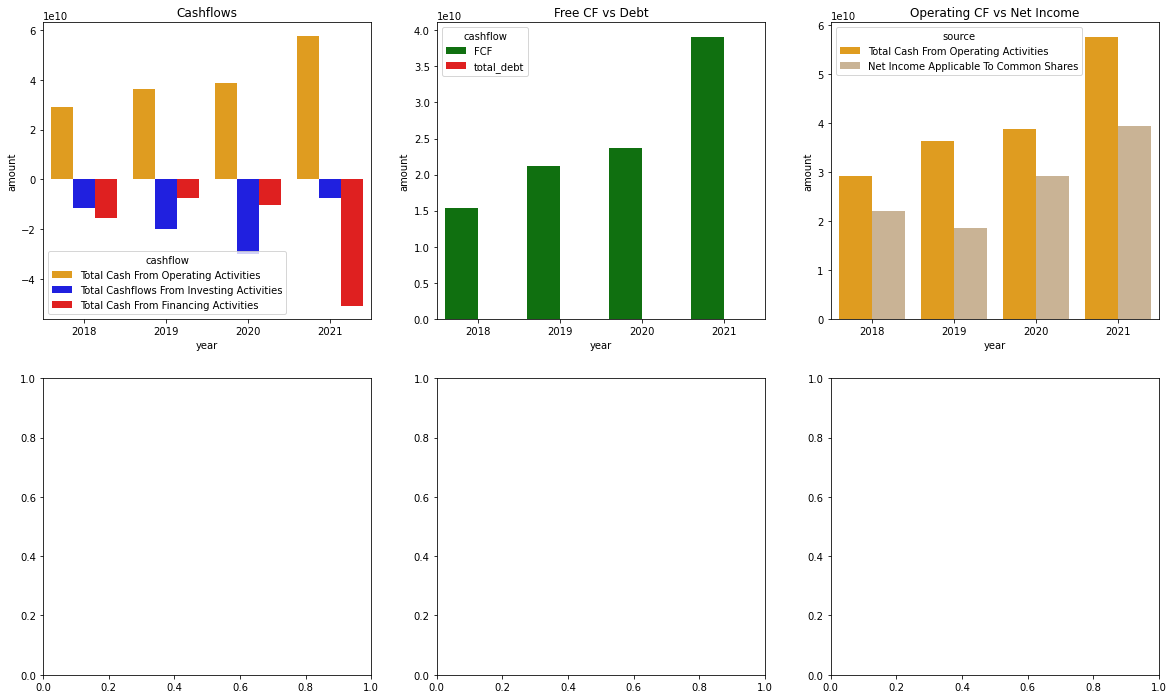

In [424]:
fig, axes = plt.subplots(2, 3,figsize=(20,12))


cashflow_df = df[["year","Total Cash From Operating Activities","Total Cashflows From Investing Activities", "Total Cash From Financing Activities"]]
cashflow_df = cashflow_df.melt(id_vars="year",var_name="cashflow",value_name="amount")
sns.barplot("year", "amount", data=cashflow_df, hue = "cashflow", palette = ["orange", "blue", "red"], order=axis, ax=axes[0,0])
axes[0,0].set(title="Cashflows")

fcf_df = df[["year","FCF", "total_debt"]]
fcf_df = fcf_df.melt(id_vars="year",var_name="cashflow",value_name="amount")
sns.barplot("year", "amount", data=fcf_df, hue = "cashflow", palette = ["green", "red"], order=axis, ax=axes[0,1])
axes[0,1].set(title="Free CF vs Debt")

cashflow_income= df[["year","Total Cash From Operating Activities",'Net Income Applicable To Common Shares']]
cashflow_income = cashflow_income.melt(id_vars="year",var_name="source",value_name="amount")
sns.barplot("year", "amount", data=cashflow_income, hue = "source", palette = ["orange", "tan"], order=axis,ax=axes[0,2])
axes[0,2].set(title="Operating CF vs Net Income")


#dividends already adjusted for stock split according to yahoo finance
dividend_history = ticker.actions
dividend_history = dividend_history.rename_axis('year').reset_index()
dividend_history["year"] = pd.DatetimeIndex(dividend_history["year"]).year
dividend_history = dividend_history[dividend_history["Stock Splits"]==0]
dividend_history = dividend_history[["year", "Dividends"]]
dividend_history = dividend_history.groupby("year").sum()

if len(dividend_history)>0:
    sns.barplot("year", "Dividends", data=dividend_history.reset_index(), color = "skyblue", ax=axes[1,0])
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].set(title="Dividends")
else:
    sns.barplot(x = axis, y=[0] * len(axis) ,color = "skyblue", ax=axes[1,0])
    axes[1,0].tick_params(axis='x', rotation=45)   
    axes[1,0].set(title="Dividends")

## balancesheet

In [ ]:
fig2, axes = plt.subplots(2, 3,figsize=(20,12))

balancesheet_prop= df[["year",'Cash', "total_debt", 'Total Assets']]
balancesheet_prop = balancesheet_prop.melt(id_vars="year",var_name="source",value_name="amount")
sns.barplot("year", "amount", data=balancesheet_prop, hue = "source", palette = ["green", "red", 'black', "black"], order=axis,ax=axes[0,0])
axes[0,0].set(title="Cash, Debt and Total Asset")

balancesheet_df = BS[["year",'Total Stockholder Equity','Total Current Liabilities','Total Liab']]
balancesheet_df["Total_long term_liab"] = balancesheet_df["Total Liab"] - balancesheet_df["Total Current Liabilities"] 
balancesheet_df.drop("Total Liab",axis="columns", inplace =True)
balancesheet_df = balancesheet_df.set_index("year").sort_index()
balancesheet_df = balancesheet_df.div(balancesheet_df.sum(axis=1), axis=0)
balancesheet_df.plot(kind='bar', stacked=True, color=['blue', 'brown', 'red'], ax=axes[0,1])
axes[0,1].set(title="Balancesheet Proportion")

sns.lineplot(df["year"], df["ROE"], ax=axes[0,2])
axes[0,2].invert_xaxis()
axes[0,2].set(title="ROE")

bs_ratio_df = df[["year","current_ratio", "debt_to_equity"]]
bs_ratio_df = bs_ratio_df.melt(id_vars="year",var_name="ratio",value_name="amount")
sns.lineplot(bs_ratio_df["year"], bs_ratio_df["amount"],hue=bs_ratio_df["ratio"], palette=["blue", "red"], ax=axes[1,0])
sns.lineplot(bs_ratio_df["year"], 1, color = "black", linestyle="--", ax=axes[1,0])
axes[1,0].invert_xaxis()
axes[1,0].set(title="Current Ratio and Debt to Equity")

# WACC calculations

## Extract lates year data

In [ ]:
latest_year = df.iloc[0]

## debt section 

In [ ]:
debt = latest_year["total_debt"]
debt

In [ ]:
total_wacc_value = debt + market_cap
total_wacc_value

In [ ]:
debt_weight = total_debt/total_wacc_value

if abs(latest_year['Interest Expense']) != 0 and debt!=0:
    debt_cost = abs(latest_year['Interest Expense']) / debt
elif abs(latest_year['Interest Expense']) == 0 and debt==0:
    debt_cost = 0
elif abs(latest_year['Interest Expense']) != 0 and debt==0:
    debt_cost = 0

tax_rate = latest_year['Income Tax Expense'] / latest_year['Income Before Tax']

## equity section

In [425]:
# beta = 1

In [426]:
beta

1.325335

In [427]:
equity_weight =  market_cap/total_wacc_value

equity_cost = risk_free_rate +  beta*(market_return_rate-risk_free_rate)

In [428]:
equity_cost

0.1260268

## WACC

In [429]:
wacc = ((equity_weight * equity_cost) + (debt_weight * debt_cost * (1-tax_rate))) + 1
wacc

1.1260268

# Discounted Growth Model

## Cashflow

In [430]:
# averge growth rate
ocf_history = list(df['Total Cash From Operating Activities'])
get_DCF_value(ocf_history)

369.84730116339074

## income

In [431]:
ic_history = list(df['Net Income Applicable To Common Shares'])
get_DCF_value(ic_history)

246.4837198737556

## Free Cash Flow

In [432]:
fcf_history = list(df["FCF"])
get_DCF_value(fcf_history)

321.2223070503201

# Dividend Discount Model 

In [371]:
if len(dividend_history)>0:
    #filter the last 4 years of dividends payment
    dividend_history = dividend_history[dividend_history.index.isin(list(df['year'].astype(int)))]
    dividend_history = dividend_history.sort_index(ascending=False)
    dividend_history = list(dividend_history["Dividends"])
    DDM_valuation = perpetual_growth_valuation(dividend_history)
else: 
    DDM_valuation = 0
    
DDM_valuation

-33.52682681292475

In [372]:
perpetual_growth_valuation(fcf_history)/shares

-2.6285767817126153

In [373]:
# to do: fix DDM model portion for stocks with no dividends
# input graphical design

In [374]:
book_value = ticker.info["bookValue"]
book_value

18.546

In [375]:
PE_ratio = ticker.info["trailingPE"]
PE_ratio

69.53847

In [376]:
ticker.info["trailingPegRatio"]

2.5044

In [377]:
ticker.info["payoutRatio"]

1.2462001

In [378]:
ticker.recommendations["To Grade"].value_counts().head(8)

Overweight       55
Equal-Weight     36
Buy              30
Hold             26
Outperform       22
Neutral          20
Equal-weight      1
Sector Weight     1
Name: To Grade, dtype: int64

# Development area

## cashflows

In [192]:
# axis = list(df["year"])
# axis = sorted(axis)
# axis

In [37]:
# cashflow_df = df[["year","Total Cash From Operating Activities","Total Cashflows From Investing Activities", "Total Cash From Financing Activities"]]
# cashflow_df = cashflow_df.melt(id_vars="year",var_name="cashflow",value_name="amount")
# sns.barplot("year", "amount", data=cashflow_df, hue = "cashflow", palette = ["orange", "blue", "red"], order=axis)

In [38]:
# fcf_df = df[["year","FCF", "total_debt"]]
# fcf_df = fcf_df.melt(id_vars="year",var_name="cashflow",value_name="amount")
# sns.barplot("year", "amount", data=fcf_df, hue = "cashflow", palette = ["green", "red"], order=axis)

In [40]:
# cashflow_income= df[["year","Total Cash From Operating Activities",'Net Income Applicable To Common Shares']]
# cashflow_income = cashflow_income.melt(id_vars="year",var_name="source",value_name="amount")
# sns.barplot("year", "amount", data=cashflow_income, hue = "source", palette = ["orange", "tan"], order=axis)

## balance sheet

In [58]:
# balancesheet_prop= df[["year",'Cash', "total_debt", 'Total Assets']]
# balancesheet_prop = balancesheet_prop.melt(id_vars="year",var_name="source",value_name="amount")
# sns.barplot("year", "amount", data=balancesheet_prop, hue = "source", palette = ["green", "red", 'black', "black"], order=axis)

In [61]:
# balancesheet_df = BS[["year",'Total Stockholder Equity','Total Current Liabilities','Total Liab']]
# balancesheet_df["Total_long term_liab"] = balancesheet_df["Total Liab"] - balancesheet_df["Total Current Liabilities"] 
# balancesheet_df.drop("Total Liab",axis="columns", inplace =True)
# balancesheet_df = balancesheet_df.set_index("year").sort_index()
# balancesheet_df = balancesheet_df.div(balancesheet_df.sum(axis=1), axis=0)
# balancesheet_df.plot(kind='bar', stacked=True, color=['blue', 'brown', 'red'])

In [67]:
# ax = sns.lineplot(df["year"], df["ROE"])
# ax.invert_xaxis()
# ax.set(title="ROE")
# ax.legend()

In [70]:
# bs_ratio_df = df[["year","current_ratio", "debt_to_equity"]]
# bs_ratio_df = bs_ratio_df.melt(id_vars="year",var_name="ratio",value_name="amount")
# ax = sns.lineplot(bs_ratio_df["year"], bs_ratio_df["amount"],hue=bs_ratio_df["ratio"], palette=["blue", "red"])
# ax = sns.lineplot(bs_ratio_df["year"], 1, color = "black", linestyle="--")
# ax.invert_xaxis()
# ax.legend()

## net income